In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob

Importing the USG-ground-based comparison data for large bolides and cleaning up the CSV file:

In [2]:
usg_ground_based_comparison = pd.read_csv('usg-ground-based-comparison.csv', sep = ',', skip_blank_lines=True).iloc[2:-3]  
# skip the first two rows after header and the last three rows since those are garbage

# forward fill Event and radiant, backward fill dv based on the xlsx file
usg_ground_based_comparison['Event'] = usg_ground_based_comparison['Event'].fillna(method='ffill')
usg_ground_based_comparison['Radiant Diff'] = usg_ground_based_comparison['Radiant Diff'].fillna(method='ffill')
usg_ground_based_comparison['DV'] = usg_ground_based_comparison['DV'].fillna(method='bfill')

# drop every other row since we don't need duplicate rows for event, radiant diff, or dv
# however we want to keep the usg reported speed (second row for each event), so we start by dropping the first row rather than the second
usg_ground_based_comparison = usg_ground_based_comparison.iloc[1::2]

/tmp/ipykernel_212210/3331784432.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usg_ground_based_comparison['Event'] = usg_ground_based_comparison['Event'].fillna(method='ffill')
/tmp/ipykernel_212210/3331784432.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usg_ground_based_comparison['Radiant Diff'] = usg_ground_based_comparison['Radiant Diff'].fillna(method='ffill')
/tmp/ipykernel_212210/3331784432.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  usg_ground_based_comparison['DV'] = usg_ground_based_comparison['DV'].fillna(method='bfill')


Sort DataFrame alphabetically by the event name (to match the order in which csvs are read from the `event` directory and its subdirectories) in-place:

In [3]:
usg_ground_based_comparison.sort_values('Event', inplace=True)

Drop Chelyabinsk for now:

In [4]:
#### # DROP CHELYABINSK FOR NOW BECAUSE WE DON'T HAVE THE USG LIGHT CURVE FOR IT YET, COMMENT THIS OUT ONCE WE DO
usg_ground_based_comparison = usg_ground_based_comparison[~usg_ground_based_comparison.Event.str.contains('Chelyabinsk', na=False)]

Now plotting speed difference and radiant difference against speed, recreating Figs. $2$ and $3$ of Brown and Borovicka:

In [5]:
# usg_ground_based_comparison = usg_ground_based_comparison[pd.to_numeric(usg_ground_based_comparison[['DV', 'Radiant Diff']], errors='coerce').notnull()].apply(pd.to_numeric, errors='coerce')
# usg_ground_based_comparison_dv = usg_ground_based_comparison[pd.to_numeric(usg_ground_based_comparison['DV'], errors='coerce').notnull()].apply(pd.to_numeric, errors='coerce')
# usg_ground_based_comparison_drad = usg_ground_based_comparison[pd.to_numeric(usg_ground_based_comparison['Radiant Diff'], errors='coerce').notnull()].apply(pd.to_numeric, errors='coerce')

# convert Speed, DV and Radiant Diff to numeric to avoid errors
usg_ground_based_comparison[['Speed', 'DV', 'Radiant Diff']] = usg_ground_based_comparison[['Speed', 'DV', 'Radiant Diff']].apply(pd.to_numeric, errors='coerce', axis=1)

# usg speed, dv, radiant_diff
usg_speed = usg_ground_based_comparison['Speed']
dv = usg_ground_based_comparison['DV']
radiant_diff = usg_ground_based_comparison['Radiant Diff']

Fig. $2$ of B&B:

(Text(0.5, 0, 'Speed (km/s)'), Text(0, 0.5, 'Speed difference (km/s)'))

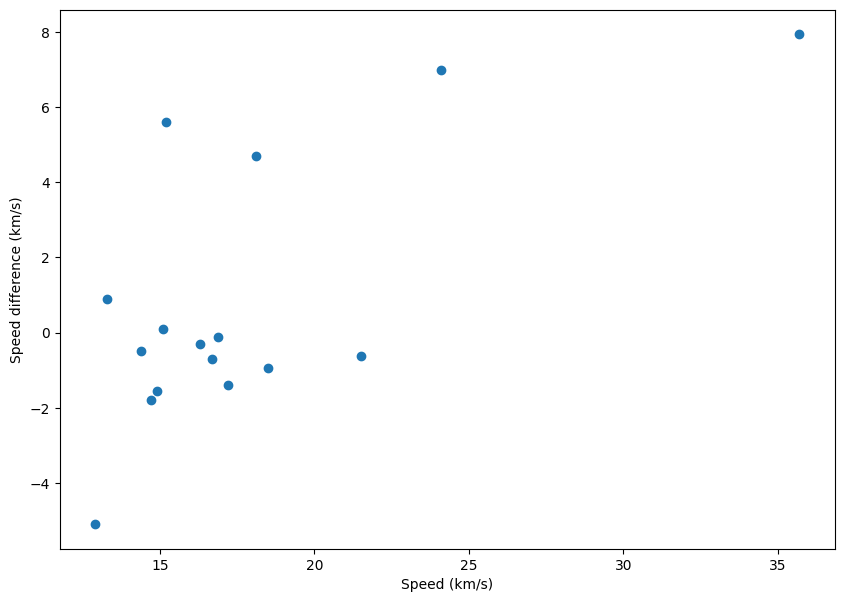

In [6]:
plt.figure(figsize = (10, 7))
plt.scatter(usg_speed, dv)
plt.xlabel('Speed (km/s)'), plt.ylabel('Speed difference (km/s)')

Fig. $3$ of B&B:

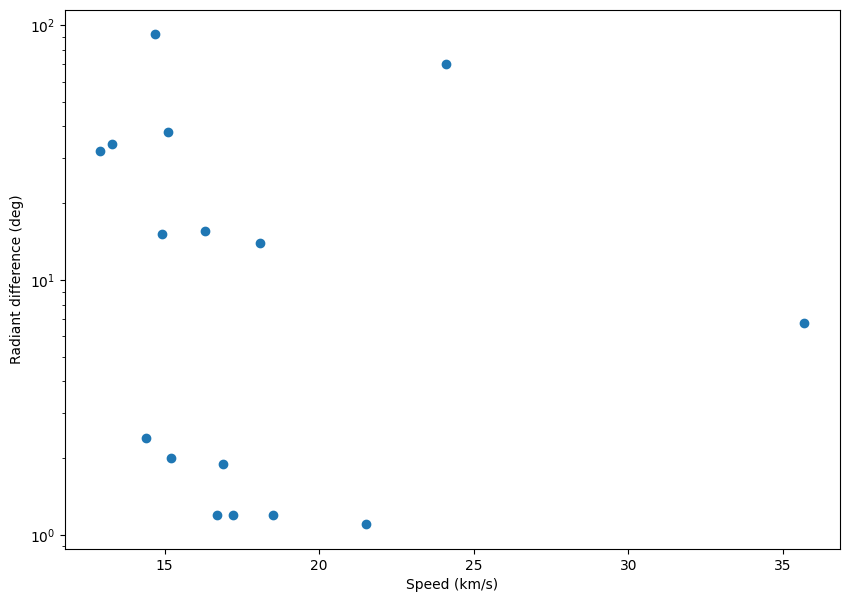

In [7]:
plt.figure(figsize = (10, 7))
# note that we use the usg reported speed (which is in our processed df) rather tahn the ground based speed (which we dropped earlier)
plt.scatter(usg_speed,radiant_diff)
plt.xlabel('Speed (km/s)'), plt.ylabel('Radiant difference (deg)')
plt.yscale('log')  # log y scale following B&B

Now plotting speed difference and radiant difference against peak intensity and lightcurve duration (from the LC data):

Get all intensity and magnitude `.csv` files for all the events (check all subdirectories of 'events') for `.csv` files. Note that these should get all the files in alphabetical order of the event folder name:

In [8]:
# should get all the intensity and magnitude files in alphabetical order of event folder name
int_files = [file for path, subdir, files in os.walk('events') for file in glob(os.path.join(path,'*_INT.csv'))] 
mag_files = [file for path, subdir, files in os.walk('events') for file in glob(os.path.join(path,'*_MAG.csv'))]

Define functions to get the peak intensities and lightcurve durations from the LC data:

In [9]:
def get_peak_intensity(intensity_csv_path):
    """
    Gets the peak intensity of a fireball event from an intensity CSV generated by the CNEOS_LC_INT_MAY-format.py script, 
    given the path 'intensity_csv_path' to the event

    param str: intensity_csv_path: file path to the intensity CSV for the fireball event

    return float: returns peak intensity value as a float
    """
    intensity_df = pd.read_csv(intensity_csv_path, header=None, names=['Time (s)', 'Intensity (W/sr)'])  # reading intensity data
    return np.float64(intensity_df['Intensity (W/sr)'].max())  # get the maximum intensity 
    
def get_lightcurve_duration(magnitude_csv_path, noise_threshold=-17.):
    """
    Gets the lightcurve duration of a fireball event from a magnitude CSV generated by the CNEOS_LC_INT_MAY-format.py script, given the path
    'magnitude_csv_path' to the event

    param str magnitude_csv_path: file path to the magnitude CSV for the fireball event
    default param float noise_threshold: noise threshold (anything below this is considered noise rather than a possible LC signal); 
    set to -17 by default

    return float duration: returns lightcurve duration as a float
    """
    # get the csv data, coerce any non numeric values to nans
    magnitude_df = pd.read_csv(magnitude_csv_path, header=None, names=['Time (s)', 'Bolometric Magnitude']).apply(pd.to_numeric, errors='coerce')
    # replace all nas with infinity, because np.inf < -17 always evaluates to False (which we want)
    magnitude_df.fillna(np.inf, inplace=True)
    # get all indices for which the bolometric magnitude is less than -17 (this is the actual light curve as anything below (greater than) that is noise)
    filtered_magnitude_df = magnitude_df['Bolometric Magnitude'] < noise_threshold
    # generate the dataframe for cumulative summation to detect changes from False to True in the column and vice versa
    cumsum_df = filtered_magnitude_df != filtered_magnitude_df.shift()
    # create dataframe with the count, start and end times of every consecutive sequence of either 'True' or 'False' in the data
    start_end_time_df = magnitude_df.groupby(cumsum_df.cumsum()).agg({'Time (s)': ['count', 'min', 'max']}).reset_index()
    start_end_time_df.columns = start_end_time_df.columns.droplevel()
    # take the actual light curve to be the longest consecutive sequence of "True" in the data (consecutive sequence of values less than
    # -17 bolometric magnitude)
    # if first sequence is noise (below noise threshold), remove every other sequence starting with the first one, 
    # since the df alternates noise-signal-noise-signal etc
    # otherwise remove every other sequence starting with the second one since the df alternates signal-noise-signal-noise etc.
    if magnitude_df['Bolometric Magnitude'][0] >= -17:
        start_end_time_df.iloc[1::2]
    elif magnitude_df['Bolometric Magnitude'][0] < -17:
        start_end_time_df.iloc[::2]
    # get the start and end times of the lcs
    lc_start_time = start_end_time_df.iloc[start_end_time_df['count'].idxmax()]['min']
    lc_end_time = start_end_time_df.iloc[start_end_time_df['count'].idxmax()]['max']
    # print(lc_start_time, lc_end_time)
    # duration is the end minus the start time
    duration = lc_end_time - lc_start_time
    # return duration
    return duration

Get the peak intensities and lightcurve durations for all the fireball intensity and magnitude `.csv` files

In [10]:
peak_intensities = np.array([get_peak_intensity(csv_file) for csv_file in int_files])
lc_durations = np.array([get_lightcurve_duration(csv_file) for csv_file in mag_files])

Now plot them against the speed and radiant difference:

In [11]:
peak_intensities, lc_durations

(array([2.51e+11, 2.93e+11, 4.97e+10, 1.73e+10, 2.09e+10, 9.14e+09,
        1.54e+10, 6.87e+09, 3.66e+09, 6.38e+11, 1.27e+11, 4.18e+10,
        2.60e+11, 4.96e+10, 9.90e+09, 5.61e+10]),
 array([2.231, 1.35 , 0.779, 1.148, 1.816, 0.311, 1.357, 1.41 , 1.384,
        2.532, 0.61 , 0.463, 1.769, 0.965, 0.648, 2.146]))

Speed and Radiant differences vs. Peak intensity:

Text(0, 0.5, 'Radiant Difference (deg)')

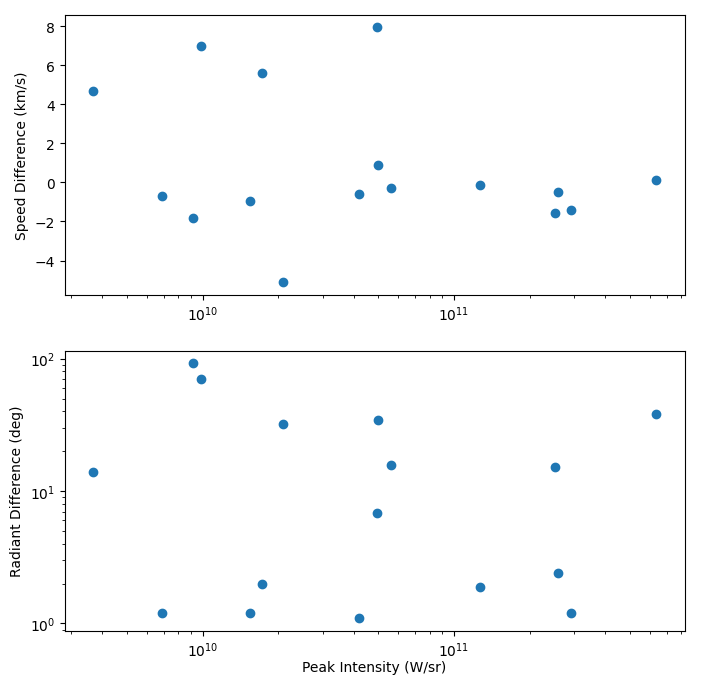

In [12]:
fig = plt.figure(figsize = (8, 8))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff
ax1.scatter(peak_intensities, dv)
# radiant diff
ax2.scatter(peak_intensities, radiant_diff)
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
# set logarithmic x scales for intensity for both
ax1.set_xscale('log')
ax2.set_xscale('log')
# label
ax.set_xlabel('Peak Intensity (W/sr)')
ax1.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
# plt.tight_layout()

Speed and Radiant differences vs. LC duration:

Text(0, 0.5, 'Radiant Difference (deg)')

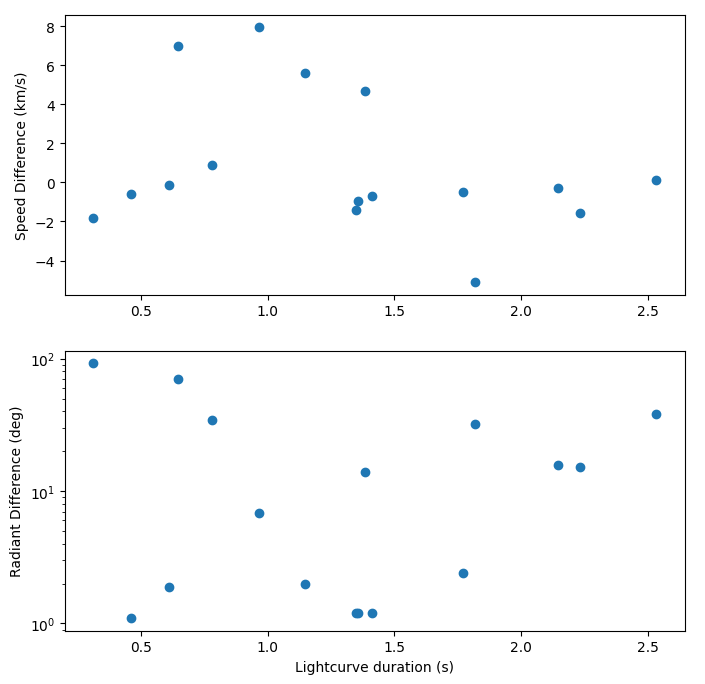

In [13]:
fig = plt.figure(figsize = (8, 8))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# speed diff
ax1.scatter(lc_durations, dv)
# radiant diff
ax2.scatter(lc_durations, radiant_diff)
ax2.set_yscale('log')  # set yscale for radiant diff to log as in b&b
# label
ax.set_xlabel('Lightcurve duration (s)')
ax1.set_ylabel('Speed Difference (km/s)')
ax2.set_ylabel('Radiant Difference (deg)')
# plt.tight_layout()

**Notes**: 

LC duration may be somewhat underestimated for some of the events because of the method used, could maybe change?

Still need to add missing Chelyabinsk LC data (and retain corresponding csv line):